In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM, Dense
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import pickle
import joblib
import os
from datetime import datetime
from collections import Counter
from nltk import ngrams

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kirubaharan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kirubaharan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data_path = 'hate_proj2.csv'
df = pd.read_csv(data_path)

# Print actual column names to debug
print("Actual columns in the dataset:", df.columns.tolist())

# Define expected columns (removed 'index' since it's not in the dataset)
expected_columns = ['tweet', 'class', 'polarity', 'corrected_class', 'class_changed']

# Check for columns (case-insensitive)
actual_columns = [col.lower() for col in df.columns]
missing_columns = [col for col in expected_columns if col.lower() not in actual_columns]
if missing_columns:
    raise ValueError(f"Dataset is missing the following columns: {missing_columns}. Actual columns: {df.columns.tolist()}")

# Ensure column names are lowercase for consistency
df.columns = [col.lower() for col in df.columns]

print(f"Dataset shape: {df.shape}")
print(f"Class distribution (original):\n{df['class'].value_counts()}")
print(f"Corrected class distribution:\n{df['corrected_class'].value_counts()}")

Actual columns in the dataset: ['tweet', 'class', 'polarity', 'corrected_class', 'class_changed']
Dataset shape: (200000, 5)
Class distribution (original):
class
1    100000
0    100000
Name: count, dtype: int64
Corrected class distribution:
corrected_class
0    137241
1     62759
Name: count, dtype: int64


In [4]:
def preprocess_text(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', str(text))
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

# Apply preprocessing to the 'tweet' column
df['cleaned_tweet'] = df['tweet'].apply(preprocess_text)
print("Preprocessing completed. 'cleaned_tweet' column created.")

Preprocessing completed. 'cleaned_tweet' column created.


In [5]:
# Labels
y = df['corrected_class'].values

# Check for NaN values in cleaned_tweet
nan_count = df['cleaned_tweet'].isna().sum()
print(f"Number of NaN values in 'cleaned_tweet': {nan_count}")
if nan_count > 0:
    print("Dropping rows with NaN in 'cleaned_tweet'...")
    df = df.dropna(subset=['cleaned_tweet'])
    y = df['corrected_class'].values
    print(f"Updated dataset shape after dropping NaNs: {df.shape}")

Number of NaN values in 'cleaned_tweet': 0


In [6]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['cleaned_tweet'])
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Prepare text data for LSTM and BERT
X_train_text, X_test_text = train_test_split(df['cleaned_tweet'].values, test_size=0.2, random_state=42)

TF-IDF matrix shape: (200000, 10000)
Training set shape: (160000, 10000)
Testing set shape: (40000, 10000)


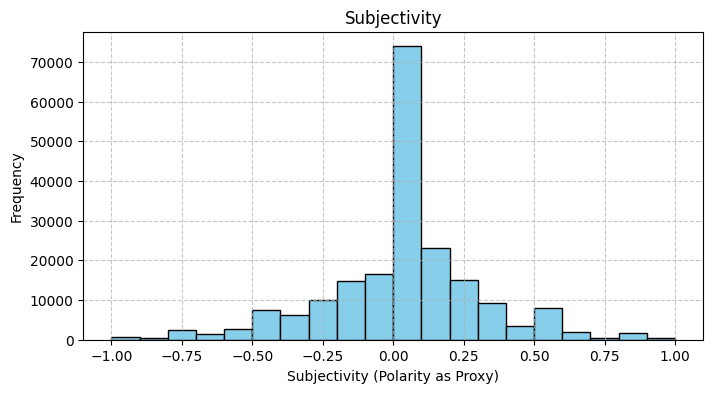

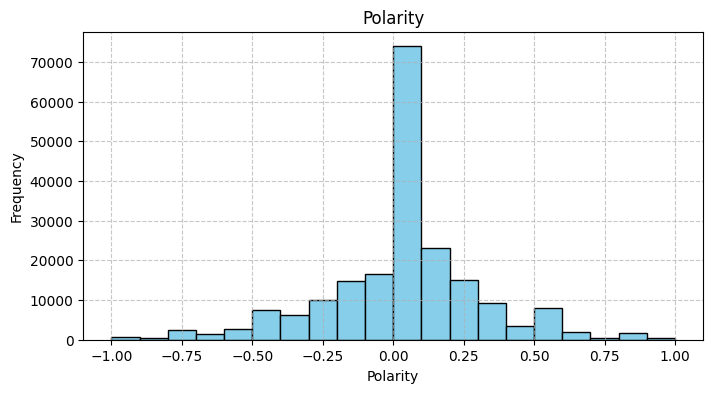

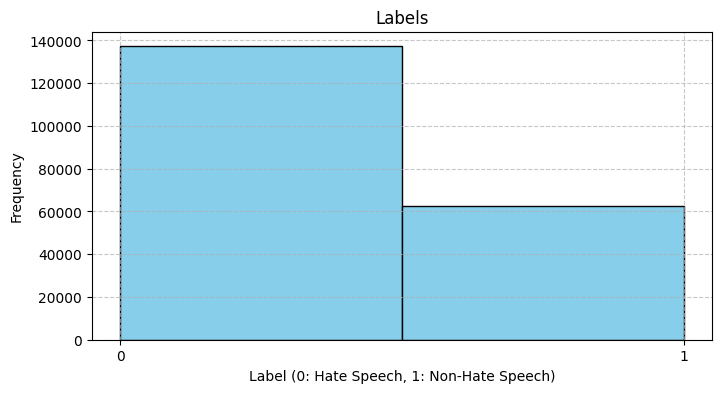

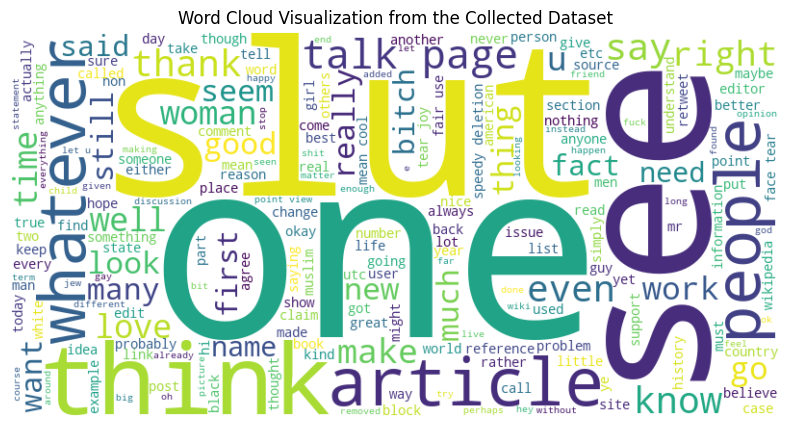

In [7]:
# Fig 4 (a): Histogram of subjectivity (using polarity as a proxy since subjectivity isn't in the dataset)
plt.figure(figsize=(8, 4))
plt.hist(df['polarity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Subjectivity')
plt.xlabel('Subjectivity (Polarity as Proxy)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Fig 4 (b): Histogram of polarity
plt.figure(figsize=(8, 4))
plt.hist(df['polarity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Fig 4 (c): Histogram of labels
plt.figure(figsize=(8, 4))
plt.hist(df['corrected_class'], bins=2, color='skyblue', edgecolor='black')
plt.title('Labels')
plt.xlabel('Label (0: Hate Speech, 1: Non-Hate Speech)')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Fig 5: Word cloud visualization
hate_tweets = ' '.join(df[df['corrected_class'] == 0]['cleaned_tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(hate_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Visualization from the Collected Dataset')
plt.show()

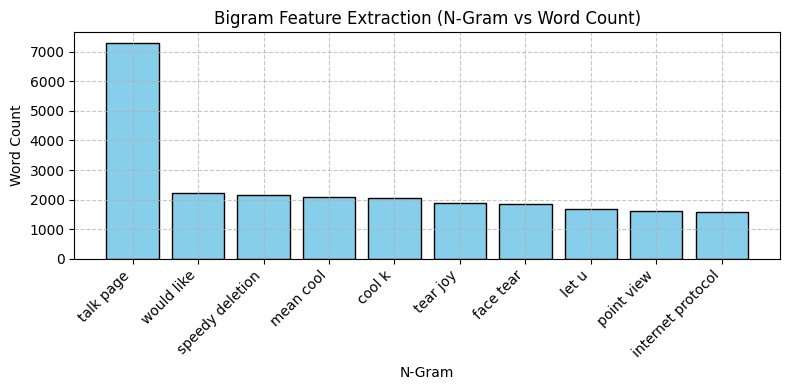

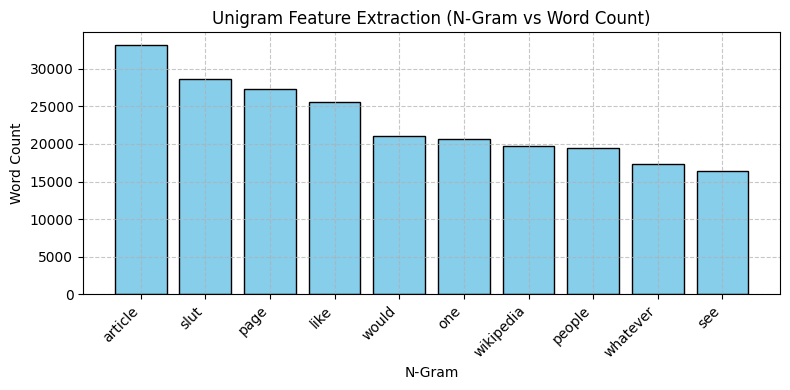

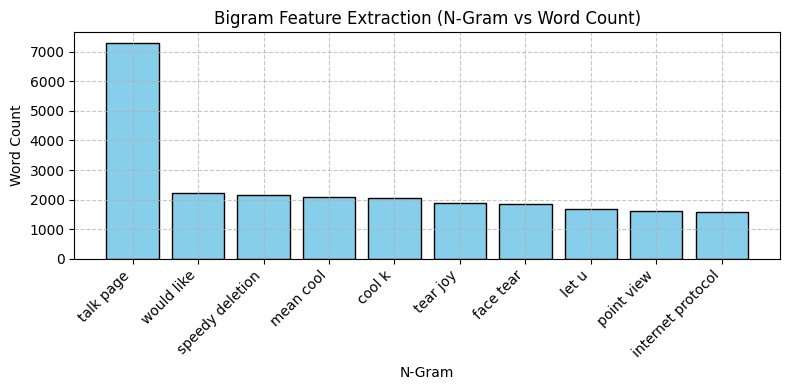

In [8]:
# Function to extract N-grams and count frequencies
def get_ngram_counts(texts, n):
    all_ngrams = []
    for text in texts:
        words = text.split()
        n_grams = list(ngrams(words, n))
        all_ngrams.extend([' '.join(gram) for gram in n_grams])
    return Counter(all_ngrams)

# Get unigrams and bigrams
unigram_counts = get_ngram_counts(df['cleaned_tweet'], 1)
bigram_counts = get_ngram_counts(df['cleaned_tweet'], 2)

# Top 10 unigrams and bigrams
top_unigrams = dict(sorted(unigram_counts.items(), key=lambda x: x[1], reverse=True)[:10])
top_bigrams = dict(sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:10])

# Fig 6 (a): Bigram feature extraction
plt.figure(figsize=(8, 4))
plt.bar(top_bigrams.keys(), top_bigrams.values(), color='skyblue', edgecolor='black')
plt.title('Bigram Feature Extraction (N-Gram vs Word Count)')
plt.xlabel('N-Gram')
plt.ylabel('Word Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Fig 6 (b): Unigram feature extraction
plt.figure(figsize=(8, 4))
plt.bar(top_unigrams.keys(), top_unigrams.values(), color='skyblue', edgecolor='black')
plt.title('Unigram Feature Extraction (N-Gram vs Word Count)')
plt.xlabel('N-Gram')
plt.ylabel('Word Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Fig 8: Bigram feature extraction (same as Fig 6a, but for context)
plt.figure(figsize=(8, 4))
plt.bar(top_bigrams.keys(), top_bigrams.values(), color='skyblue', edgecolor='black')
plt.title('Bigram Feature Extraction (N-Gram vs Word Count)')
plt.xlabel('N-Gram')
plt.ylabel('Word Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
from sklearn.svm import LinearSVC  # Using LinearSVC instead of SVC for faster training

# Create a temporary directory for intermediate saves (if not already created)
temp_model_dir = "temp_models"
if not os.path.exists(temp_model_dir):
    os.makedirs(temp_model_dir)

# Define models with optimized hyperparameters for faster training
models = {
    'SVM': LinearSVC(max_iter=1000),  # Replaced SVC with LinearSVC
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, n_jobs=-1),  # Reduced n_estimators, added n_jobs
    'XGBoost': XGBClassifier(n_estimators=50, max_depth=6, eval_metric='logloss'),  # Reduced n_estimators, limited depth
    'k-NN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),  # Added n_jobs
    'ANN': MLPClassifier(hidden_layer_sizes=(50,), max_iter=200)  # Reduced size and iterations
}

results = {}
y_pred_probs = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # For AUC, we need probability scores
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_prob = model.decision_function(X_test) if hasattr(model, "decision_function") else y_pred
    y_pred_probs[name] = y_pred_prob
    # Calculate and store metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_prob)
    }
    # Print the accuracy for this model
    print(f"{name} Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"{name} Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"{name} Precision: {results[name]['Precision']:.4f}")
    print(f"{name} Recall: {results[name]['Recall']:.4f}")
    print(f"{name} F1-Score: {results[name]['F1-Score']:.4f}")
    print(f"{name} AUC: {results[name]['AUC']:.4f}")
    # Save the model immediately after training
    try:
        joblib.dump(model, os.path.join(temp_model_dir, f'{name}_model.joblib'))
        print(f"Saved {name} model to {temp_model_dir}")
    except Exception as e:
        print(f"Error saving {name} model: {str(e)}")
    print(f"{name} completed.")

Training SVM...
SVM Accuracy: 0.9002
SVM Accuracy: 0.9002
SVM Precision: 0.8887
SVM Recall: 0.7809
SVM F1-Score: 0.8313
SVM AUC: 0.9431
Saved SVM model to temp_models
SVM completed.
Training Naive Bayes...
Naive Bayes Accuracy: 0.8265
Naive Bayes Accuracy: 0.8265
Naive Bayes Precision: 0.8752
Naive Bayes Recall: 0.5236
Naive Bayes F1-Score: 0.6552
Naive Bayes AUC: 0.8518
Saved Naive Bayes model to temp_models
Naive Bayes completed.
Training Logistic Regression...
Logistic Regression Accuracy: 0.8879
Logistic Regression Accuracy: 0.8879
Logistic Regression Precision: 0.8995
Logistic Regression Recall: 0.7247
Logistic Regression F1-Score: 0.8027
Logistic Regression AUC: 0.9415
Saved Logistic Regression model to temp_models
Logistic Regression completed.
Training Random Forest...
Random Forest Accuracy: 0.8954
Random Forest Accuracy: 0.8954
Random Forest Precision: 0.8412
Random Forest Recall: 0.8232
Random Forest F1-Score: 0.8321
Random Forest AUC: 0.9407
Saved Random Forest model to tem

In [ ]:
models = {
    'SVM': SVC(kernel='linear', probability=True),
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'ANN': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

results = {}
y_pred_probs = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_prob = model.decision_function(X_test) if hasattr(model, "decision_function") else y_pred
    y_pred_probs[name] = y_pred_prob
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_prob)
    }
    # Save the model immediately after training
    try:
        joblib.dump(model, os.path.join(temp_model_dir, f'{name}_model.joblib'))
        print(f"Saved {name} model to {temp_model_dir}")
    except Exception as e:
        print(f"Error saving {name} model: {str(e)}")
    print(f"{name} completed.")

Training SVM...
SVM completed.
Training Naive Bayes...
Naive Bayes completed.
Training Logistic Regression...
Logistic Regression completed.
Training Random Forest...
Random Forest completed.
Training XGBoost...


c:\Users\kirubaharan\anaconda3\envs\tf_env_310\lib\site-packages\xgboost\training.py:183: UserWarning: [01:26:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost completed.
Training k-NN...
k-NN completed.
Training ANN...
ANN completed.


In [12]:
# Create a temporary directory for intermediate saves (if not already created)
temp_model_dir = "temp_models"
if not os.path.exists(temp_model_dir):
    os.makedirs(temp_model_dir)

# LSTM Training
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_tweet'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_tweet'])
X_pad = pad_sequences(X_seq, maxlen=100)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, y, test_size=0.2, random_state=42)

lstm_model = Sequential([
    Input(shape=(100,), dtype='int32', name='input_layer'),
    Embedding(input_dim=5000, output_dim=128),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Training LSTM...")
history_lstm = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=15, batch_size=64, validation_split=0.2, verbose=1)

# Save the LSTM model and tokenizer immediately after training
try:
    lstm_model.save(os.path.join(temp_model_dir, 'lstm_hate_speech_model.keras'), save_format='keras_v3')
    print(f"Saved LSTM model to {temp_model_dir}")
    with open(os.path.join(temp_model_dir, 'tokenizer.pkl'), 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Saved tokenizer to {temp_model_dir}")
except Exception as e:
    print(f"Error saving LSTM model or tokenizer: {str(e)}")

Training LSTM...
Epoch 1/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 270s 132ms/step - accuracy: 0.8224 - loss: 0.4077 - val_accuracy: 0.9055 - val_loss: 0.2599
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 255s 127ms/step - accuracy: 0.9113 - loss: 0.2479 - val_accuracy: 0.9123 - val_loss: 0.2472
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 262s 131ms/step - accuracy: 0.9188 - loss: 0.2241 - val_accuracy: 0.9128 - val_loss: 0.2453
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 281s 141ms/step - accuracy: 0.9239 - loss: 0.2083 - val_accuracy: 0.9126 - val_loss: 0.2467
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 278s 139ms/step - accuracy: 0.9307 - loss: 0.1881 - val_accuracy: 0.9126 - val_loss: 0.2548
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 275s 138ms/step - accuracy: 0.9368 - loss: 0.1735 - val_accuracy: 0.9108 - val_loss: 0.2660
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 287s 144ms/step - accuracy: 0.9419 - loss: 0.1589 - val_accuracy: 0.9108 - val_loss: 0.2824
Epoch 8/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 292

Saved LSTM model to temp_models
Saved tokenizer to temp_models


In [14]:
# Create a temporary directory for intermediate saves (if not already created)
temp_model_dir = "temp_models"
if not os.path.exists(temp_model_dir):
    os.makedirs(temp_model_dir)

# LSTM Training
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_tweet'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_tweet'])
X_pad = pad_sequences(X_seq, maxlen=100)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, y, test_size=0.2, random_state=42)

lstm_model = Sequential([
    Input(shape=(100,), dtype='int32', name='input_layer'),  # Changed batch_input_shape to shape
    Embedding(input_dim=5000, output_dim=128),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Training LSTM...")
history_lstm = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=18, batch_size=64, validation_split=0.2, verbose=1)

# Save the LSTM model and tokenizer immediately after training
try:
    lstm_model.save(os.path.join(temp_model_dir, 'lstm_hate_speech_model.keras'), save_format='keras_v3')
    print(f"Saved LSTM model to {temp_model_dir}")
    with open(os.path.join(temp_model_dir, 'tokenizer.pkl'), 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Saved tokenizer to {temp_model_dir}")
except Exception as e:
    print(f"Error saving LSTM model or tokenizer: {str(e)}")

# Evaluate the model
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int).flatten()
y_pred_lstm_prob = lstm_model.predict(X_test_lstm).flatten()
results['LSTM'] = {
    'Accuracy': accuracy_score(y_test_lstm, y_pred_lstm),
    'Precision': precision_score(y_test_lstm, y_pred_lstm),
    'Recall': recall_score(y_test_lstm, y_pred_lstm),
    'F1-Score': f1_score(y_test_lstm, y_pred_lstm),
    'AUC': roc_auc_score(y_test_lstm, y_pred_lstm_prob)
}
print("LSTM completed.")

Training LSTM...
Epoch 1/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 272s 133ms/step - accuracy: 0.8235 - loss: 0.4057 - val_accuracy: 0.9050 - val_loss: 0.2598
Epoch 2/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 248s 124ms/step - accuracy: 0.9105 - loss: 0.2475 - val_accuracy: 0.9110 - val_loss: 0.2502
Epoch 3/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 263s 131ms/step - accuracy: 0.9169 - loss: 0.2288 - val_accuracy: 0.9136 - val_loss: 0.2444
Epoch 4/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 252s 126ms/step - accuracy: 0.9262 - loss: 0.2045 - val_accuracy: 0.9132 - val_loss: 0.2524
Epoch 5/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 270s 135ms/step - accuracy: 0.9295 - loss: 0.1906 - val_accuracy: 0.9102 - val_loss: 0.2571
Epoch 6/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 273s 137ms/step - accuracy: 0.9375 - loss: 0.1691 - val_accuracy: 0.9113 - val_loss: 0.2642
Epoch 7/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 278s 139ms/step - accuracy: 0.9437 - loss: 0.1554 - val_accuracy: 0.9108 - val_loss: 0.2768
Epoch 8/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 288

Saved LSTM model to temp_models
Saved tokenizer to temp_models
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step
LSTM completed.


In [11]:
# Create a temporary directory for intermediate saves (if not already created)
from transformers import AdamW
temp_model_dir = "temp_models"
if not os.path.exists(temp_model_dir):
    os.makedirs(temp_model_dir)

# BERT Training
def encode_texts(texts, max_len=100):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_len, return_tensors='tf')
    return {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']}

df_bert = df.sample(15000, random_state=42) if len(df) > 15000 else df
y_bert = df_bert['corrected_class'].values

X_train_texts, X_temp_texts, y_train_bert, y_temp = train_test_split(
    df_bert['cleaned_tweet'].values, y_bert, test_size=0.3, random_state=42
)
X_val_texts, X_test_texts, y_val_bert, y_test_bert = train_test_split(
    X_temp_texts, y_temp, test_size=0.5, random_state=42
)

X_train_bert = encode_texts(pd.Series(X_train_texts))
X_val_bert = encode_texts(pd.Series(X_val_texts))
X_test_bert = encode_texts(pd.Series(X_test_texts))

train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_train_bert['input_ids'], 'attention_mask': X_train_bert['attention_mask']},
    y_train_bert
)).shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_val_bert['input_ids'], 'attention_mask': X_val_bert['attention_mask']},
    y_val_bert
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_test_bert['input_ids'], 'attention_mask': X_test_bert['attention_mask']},
    y_test_bert
)).batch(16)

bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Use 'adam' as a string identifier and specify learning rate separately
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
bert_model.compile(
    optimizer='adam',  # Pass optimizer as string
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Training BERT...")
history_bert = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=8,
    verbose=1
)

# Save the BERT model and tokenizer immediately after training
try:
    bert_model.save_pretrained(os.path.join(temp_model_dir, 'bert_hate_speech_model'))
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_tokenizer.save_pretrained(os.path.join(temp_model_dir, 'bert_hate_speech_model'))
    print(f"Saved BERT model and tokenizer to {temp_model_dir}")
except Exception as e:
    print(f"Error saving BERT model or tokenizer: {str(e)}")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training BERT...
Epoch 1/8


657/657 [==============================] - 3240s 5s/step - loss: 0.6398 - accuracy: 0.6883 - val_loss: 0.6217 - val_accuracy: 0.6907
Epoch 2/8
657/657 [==============================] - 3156s 5s/step - loss: 0.6280 - accuracy: 0.6917 - val_loss: 0.6198 - val_accuracy: 0.6907
Epoch 3/8
657/657 [==============================] - 3239s 5s/step - loss: 0.6238 - accuracy: 0.6949 - val_loss: 0.6188 - val_accuracy: 0.6907
Epoch 4/8
657/657 [==============================] - 3217s 5s/step - loss: 0.6201 - accuracy: 0.6950 - val_loss: 0.6186 - val_accuracy: 0.6907
Epoch 5/8
657/657 [==============================] - 3518s 5s/step - loss: 0.6195 - accuracy: 0.6950 - val_loss: 0.6206 - val_accuracy: 0.6907
Epoch 6/8
657/657 [==============================] - 3323s 5s/step - loss: 0.6194 - accuracy: 0.6950 - val_loss: 0.6201 - val_accuracy: 0.6907
Epoch 7/8
657/657 [==============================] - 3338s 5s/step - loss: 0.6179 - accuracy: 0.6950 - val_loss: 0.6191 - 

In [12]:
# Evaluate the model
y_pred_bert_logits = bert_model.predict(test_dataset).logits
y_pred_bert = np.argmax(y_pred_bert_logits, axis=1)
y_pred_bert_prob = tf.nn.softmax(y_pred_bert_logits, axis=1)[:, 1].numpy()
results['BERT'] = {
    'Accuracy': accuracy_score(y_test_bert, y_pred_bert),
    'Precision': precision_score(y_test_bert, y_pred_bert),
    'Recall': recall_score(y_test_bert, y_pred_bert),
    'F1-Score': f1_score(y_test_bert, y_pred_bert),
    'AUC': roc_auc_score(y_test_bert, y_pred_bert_prob)
}
print("BERT completed.")

141/141 [==============================] - 196s 1s/step
BERT completed.


c:\Users\kirubaharan\anaconda3\envs\tf_env_310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Performance Metrics:
                     Accuracy  Precision    Recall  F1-Score       AUC
SVM                  0.900225   0.888658  0.780893  0.831297  0.943111
Naive Bayes          0.826525   0.875216  0.523586  0.655205  0.851797
Logistic Regression  0.887850   0.899547  0.724666  0.802692  0.941521
Random Forest        0.895425   0.841191  0.823221  0.832109  0.940712
XGBoost              0.841300   0.873445  0.579892  0.697022  0.889226
k-NN                 0.739550   0.847506  0.210530  0.337277  0.695987
ANN                  0.902025   0.860264  0.822348  0.840879  0.942503
BERT                 0.685778   0.000000  0.000000  0.000000  0.499853
LSTM                 0.895175   0.832528  0.834975  0.833750  0.930576


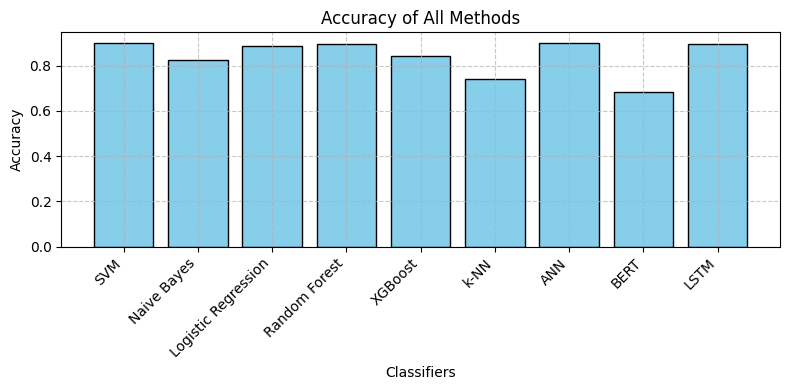

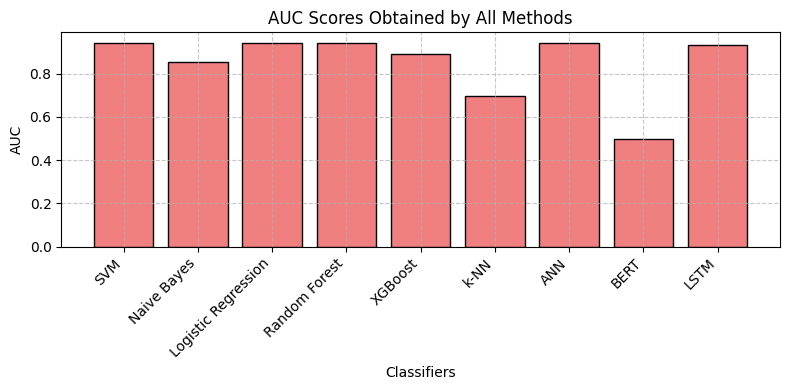

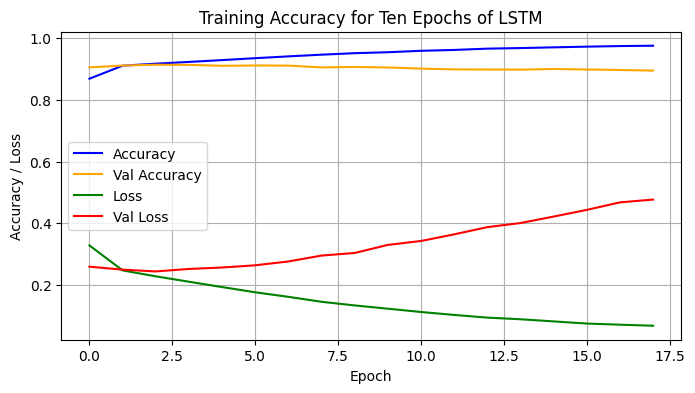

In [15]:
results_df = pd.DataFrame(results).T
print("Model Performance Metrics:")
print(results_df)

# Fig 7: Accuracy of all methods
plt.figure(figsize=(8, 4))
plt.bar(results_df.index, results_df['Accuracy'], color='skyblue', edgecolor='black')
plt.title('Accuracy of All Methods')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Fig 9: AUC scores obtained by all methods
plt.figure(figsize=(8, 4))
plt.bar(results_df.index, results_df['AUC'], color='lightcoral', edgecolor='black')
plt.title('AUC Scores Obtained by All Methods')
plt.xlabel('Classifiers')
plt.ylabel('AUC')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Fig 10: Training accuracy for ten epochs of LSTM
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history['accuracy'], label='Accuracy', color='blue')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.plot(history_lstm.history['loss'], label='Loss', color='green')
plt.plot(history_lstm.history['val_loss'], label='Val Loss', color='red')
plt.title('Training Accuracy for Ten Epochs of LSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
def predict_all_models(text):
    cleaned_text = preprocess_text(text)
    
    X_input_tfidf = tfidf.transform([cleaned_text])
    tfidf_predictions = {name: model.predict(X_input_tfidf)[0] for name, model in models.items()}
    
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=100)
    lstm_prediction = lstm_model.predict(padded_sequence, verbose=0)[0][0]
    
    bert_input = encode_texts(pd.Series([cleaned_text]))
    bert_prediction_logits = bert_model.predict(
        [bert_input['input_ids'], bert_input['attention_mask']], verbose=0
    ).logits
    bert_prediction = np.argmax(bert_prediction_logits, axis=1)[0]
    
    results = {}
    for name, pred in tfidf_predictions.items():
        results[name] = "Non-Hate Speech" if pred == 0 else "Hate Speech"
    results['LSTM'] = "Non-Hate Speech" if lstm_prediction < 0.5 else "Hate Speech"
    results['BERT'] = "Non-Hate Speech" if bert_prediction == 0 else "Hate Speech"
    
    return results

# Interactive prediction
while True:
    user_input = input("Enter text to classify (or 'quit' to exit): ")
    if user_input.lower() == 'quit':
        break
    if not user_input.strip():
        print("Please enter some text!")
        continue
    
    try:
        predictions = predict_all_models(user_input)
        print(f"\nPredictions for input text: '{user_input}'")
        for model, result in predictions.items():
            print(f"{model}: {result}")
        print()
    except Exception as e:
        print(f"Error during prediction: {str(e)}")


Predictions for input text: 'good morning kiruba'
SVM: Non-Hate Speech
Naive Bayes: Non-Hate Speech
Logistic Regression: Non-Hate Speech
Random Forest: Non-Hate Speech
XGBoost: Non-Hate Speech
k-NN: Non-Hate Speech
ANN: Non-Hate Speech
LSTM: Non-Hate Speech
BERT: Non-Hate Speech


Predictions for input text: 'good bad ugly man'
SVM: Hate Speech
Naive Bayes: Hate Speech
Logistic Regression: Hate Speech
Random Forest: Non-Hate Speech
XGBoost: Non-Hate Speech
k-NN: Hate Speech
ANN: Hate Speech
LSTM: Hate Speech
BERT: Non-Hate Speech


Predictions for input text: 'i will kill you bro'
SVM: Non-Hate Speech
Naive Bayes: Non-Hate Speech
Logistic Regression: Non-Hate Speech
Random Forest: Non-Hate Speech
XGBoost: Non-Hate Speech
k-NN: Non-Hate Speech
ANN: Non-Hate Speech
LSTM: Non-Hate Speech
BERT: Non-Hate Speech



In [20]:
model_dir = "saved_models_2025-03-23_12-14-00"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

print(f"Saving models at UTC: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')}")

print("Saving TF-IDF vectorizer...")
joblib.dump(tfidf, os.path.join(model_dir, 'tfidf_vectorizer.joblib'))
print("TF-IDF vectorizer saved successfully")

print("Saving classification models...")
for name, model in models.items():
    try:
        joblib.dump(model, os.path.join(model_dir, f'{name}_model.joblib'))
        print(f"Saved {name} model successfully")
    except Exception as e:
        print(f"Error saving {name} model: {str(e)}")

print("\nSaving LSTM model and tokenizer...")
try:
    lstm_model.save(os.path.join(model_dir, 'lstm_hate_speech_model.keras'), save_format='keras_v3')
    with open(os.path.join(model_dir, 'tokenizer.pkl'), 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("LSTM model and tokenizer saved successfully")
except Exception as e:
    print(f"Error saving LSTM model or tokenizer: {str(e)}")

print("\nSaving BERT model and tokenizer...")
try:
    bert_model.save_pretrained(os.path.join(model_dir, 'bert_hate_speech_model'))
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_tokenizer.save_pretrained(os.path.join(model_dir, 'bert_hate_speech_model'))
    print("BERT model and tokenizer saved successfully")
except Exception as e:
    print(f"Error saving BERT model or tokenizer: {str(e)}")

print(f"\nAll models saved in directory: {model_dir}")

Saving models at UTC: 2025-03-23 07:06:20
Saving TF-IDF vectorizer...
TF-IDF vectorizer saved successfully
Saving classification models...
Saved SVM model successfully
Saved Naive Bayes model successfully
Saved Logistic Regression model successfully
Saved Random Forest model successfully
Saved XGBoost model successfully
Saved k-NN model successfully


Saved ANN model successfully

Saving LSTM model and tokenizer...
LSTM model and tokenizer saved successfully

Saving BERT model and tokenizer...
BERT model and tokenizer saved successfully

All models saved in directory: saved_models_2025-03-23_12-14-00
